# Texture prediction

Many objects have self-repeating textures. One way to synthesise them based on templates:

* You build a model for predicting single pixel from its neighbours
* You use it iteratively to synthesise texture pixel-by-pixel.

If you take a symmetric neigbours you get cyclic depencencies. These can be solved by during iterative predictions until the process converges. This technique is known as [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) and it is related to limiting distribution of Markov Chains. 
Such texture syntesis is equivalent of defining a Markov Field. We will discuss this further on.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

from tqdm.notebook import tnrange 
from matplotlib import pyplot as plt
from matplotlib import gridspec

# Local imports
from common import *
from convenience import *

## I. Template textures

* We use images of bark and moss as templates for textures. 
* For simplicity, we convert both images to grayscale. 
* Then we have to predict only luminocity of a pixel. 

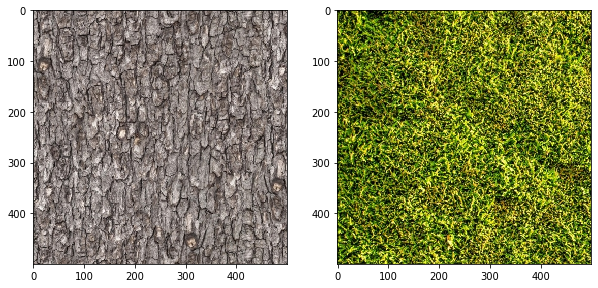

In [2]:
# Let us extract 500 x 500 subimages
bark = plt.imread('data/textures/bark.png')[:500, :500, :]
moss = plt.imread('data/textures/moss.png')[:500, :500, :]

fig=plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(bark)
fig.add_subplot(1, 2, 2)
plt.imshow(moss)

### Luminocity based grayscale conversion

In [3]:
def convert_to_grayscale(image: np.array)-> np.array:
    """Converts RGB image to grayscale image preserving perceived luminocity based on Y_601 formula""" 
    return 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]

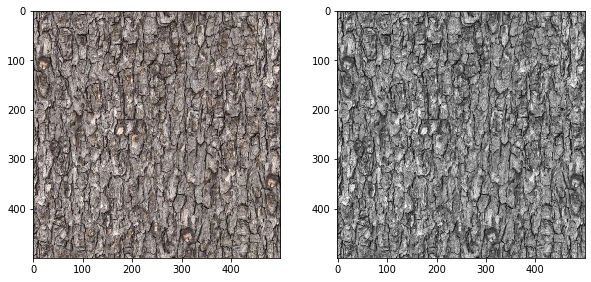

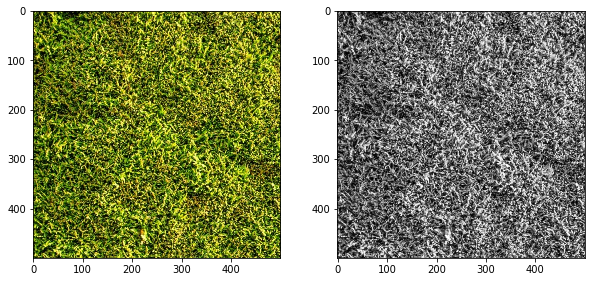

In [4]:
bw_bark = convert_to_grayscale(bark)
bw_moss = convert_to_grayscale(moss)

fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 2, 1)
plt.imshow(bark)
fig.add_subplot(2, 2, 2)
plt.imshow(bw_bark, cmap='gray')
fig = plt.figure(figsize=(10,10))
fig.add_subplot(2, 2, 3)
plt.imshow(moss)
fig.add_subplot(2, 2, 4)
plt.imshow(bw_moss, cmap='gray')

## II. Neighbourhood extraction

### Extraction of texture windows with corresponding labels

Note that grayscale image is just a $m\times n$ matrix and a neighbourhood of a pixel $(x,y)$ is just a submatrix.
* For every coordinate $(x,y)$ we extract a $(2d+1)\times(2d+1)$ window centered in $(x,y)$.
* For simplicity, we ignore all coordinates where one of the following conditions is satisfied:

\begin{align*}
&\begin{aligned}
x&< d\,,\\
x&\geq m-d\,,
\end{aligned}
&
&\begin{aligned}
y&< d\,,\\
y&\geq n-d\,.
\end{aligned}
\end{align*}

In [5]:
def extract_texture_vectors(bw_image: np.array, x: np.array, y:np.array, m: int, n: int, d: int) -> DataFrame:
    
    index = (d <= x) & (x < m - d) & (d <= y) & (y < n - d)
    xm = x[index]
    ym = y[index]
    
    x0 = xm - d
    x1 = xm + d + 1
    y0 = ym - d
    y1 = ym + d + 1
    
    r = len(xm)
    textures = np.empty([r, (2 * d + 1)**2])
    for i in range(r):
        textures[i, :] = bw_image[x0[i]:x1[i], y0[i]:y1[i]].flatten()
        
    columns = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)]   
    return (DataFrame(textures, columns = columns)
            .assign(xm = Series(xm).astype(int))
            .assign(ym = Series(ym).astype(int))
            [['xm', 'ym'] + columns])

Simple test that the function works as expected. The column **x05** corresponds to the pixel.

In [6]:
extract_texture_vectors(bw_bark, x = np.array([10, 20]), y = np.array([10, 20]), m = 500, n = 500, d = 1)

,xm,ym,x01,x02,x03,x04,x05,x06,x07,x08,x09
0,10,10,0.438683,0.635914,0.663362,0.399024,0.615136,0.673953,0.362114,0.615136,0.666111
1,20,20,0.435487,0.243349,0.255113,0.541358,0.298246,0.259034,0.487187,0.362156,0.408038


* More complex test to see that the location extracted patches are correct.
* Note that in visualisation $x$-coordinate goes from top to bottom and $y$-coordinate from left to right. 

,xm,ym,x01,x02,x03,x04,x05,x06,x07,x08,...,x10192,x10193,x10194,x10195,x10196,x10197,x10198,x10199,x10200,x10201
0,51,51,0.596617,0.678962,0.741701,0.702489,0.411192,0.379823,0.615540,0.317531,...,0.423681,0.434272,0.407996,0.529553,0.436616,0.473526,0.579398,0.577779,0.624108,0.435891
1,152,51,0.542488,0.593464,0.566015,0.600134,0.455050,0.149198,0.317809,0.509947,...,0.674787,0.470886,0.368489,0.293986,0.392463,0.469714,0.372132,0.281220,0.416116,0.596491
2,51,152,0.435040,0.329615,0.285757,0.273993,0.313205,0.309284,0.357510,0.439855,...,0.405398,0.477152,0.481798,0.494244,0.521693,0.530429,0.405398,0.424279,0.536138,0.297841
3,152,152,0.388837,0.537842,0.568764,0.517789,0.349626,0.333941,0.251149,0.359812,...,0.517258,0.441626,0.450640,0.431717,0.344279,0.466282,0.376095,0.321157,0.441988,0.426025


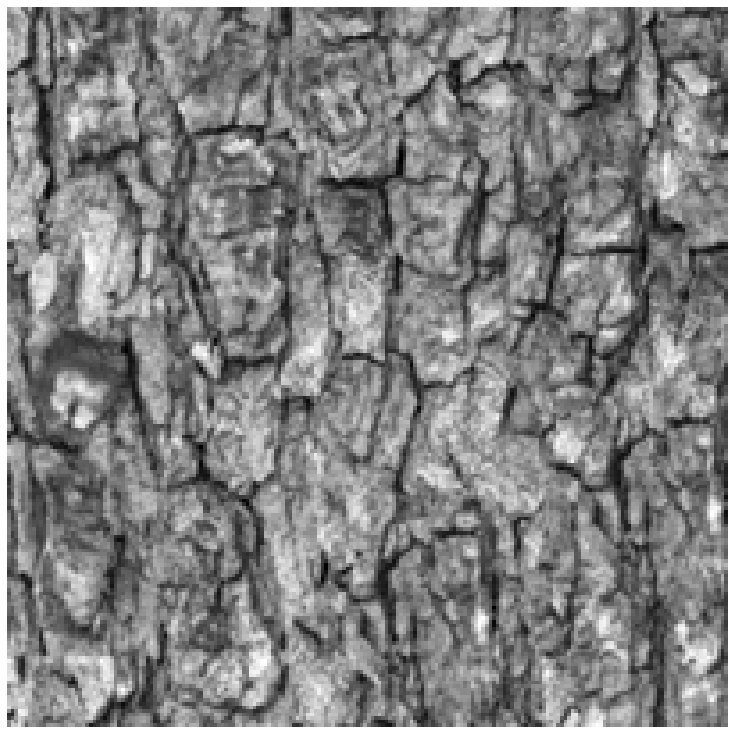

In [7]:
df = extract_texture_vectors(
    bw_bark, 
    x = np.array([51, 152, 51, 152]), 
    y = np.array([51, 51, 152, 152]), 
    m = 500, n = 500, d = 50)

display(df)

plt.figure(figsize=(10,10))
plt.tight_layout()
gs = gridspec.GridSpec(2, 2)
plt.subplot(gs[0])
plt.axis('off')
plt.imshow(np.reshape(df.iloc[0,2:].values, (101, 101)), cmap='gray')
plt.subplot(gs[1])
plt.imshow(np.reshape(df.iloc[2,2:].values, (101, 101)), cmap='gray')
plt.axis('off')
plt.subplot(gs[2])
plt.imshow(np.reshape(df.iloc[1,2:].values, (101, 101)), cmap='gray')
plt.axis('off')
plt.subplot(gs[3])
plt.imshow(np.reshape(df.iloc[3,2:].values, (101, 101)), cmap='gray')
plt.axis('off')
plt.subplots_adjust(wspace=0.00, hspace=0.00, left=0, right=1, bottom=0, top=1)

## III. Training data collection

* Let us use the simplest $3 \times 3$ neighbourhoods for the prediction of the center pixel.
* As a trainingset we sample 5000 patches from random locations.
* For clarity we define data matrix $X$ and a target vector $\mathbf{y}$.

In [8]:
# Sampling
d = 1
m = 500
n = 500
r = 5000
x = np.random.choice(range(d, m - d), size=r, replace = True)
y = np.random.choice(range(d, n - d), size=r, replace = True)
df = extract_texture_vectors(bw_bark, x, y, m, n , d)

# Preparations for prediction 
X = df.iloc[:, 2:].drop(columns=['x05'])
y = df['x05']
mdisplay([head(df[['xm', 'ym']]), head(X), head(DataFrame(y, columns=['x05']))], 
         ['Locations', 'Data matrix X', 'Target vector y'])


Locations Data matrix X Target vector y 
 
 
 xm 
 ym 
 
 
 
 
 57 
 246 
 
 
 28 
 494 
 
 
 41 
 117 
 
 
 32 
 41 
 
 
 321 
 91 
 
 
 
 
 
 x01 
 x02 
 x03 
 x04 
 x06 
 x07 
 x08 
 x09 
 
 
 
 
 0.304916 
 0.320600 
 0.375497 
 0.414709 
 0.473526 
 0.418630 
 0.442157 
 0.355891 
 
 
 0.286887 
 0.444181 
 0.376391 
 0.239833 
 0.148516 
 0.360942 
 0.375944 
 0.317126 
 
 
 0.618441 
 0.598835 
 0.449383 
 0.583150 
 0.524333 
 0.489042 
 0.528254 
 0.500805 
 
 
 0.439855 
 0.412407 
 0.427644 
 0.466131 
 0.504896 
 0.493579 
 0.662190 
 0.626452 
 
 
 0.373110 
 0.518194 
 0.502062 
 0.345662 
 0.407954 
 0.329977 
 0.435849 
 0.494667 
 
 
 
 
 
 x05 
 
 
 
 
 0.418630 
 
 
 0.229688 
 
 
 0.630204 
 
 
 0.517106 
 
 
 0.420164

## IV. Linear regression

### Finding regression coefficients and the variance parameter 

We will use linear regression to predict the intensity of the center pixel.

In [9]:
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import plot
from matplotlib.pyplot import bar as bar_plot

R^2 score: 0.9263041317637328
sigma=0.04147444068820684


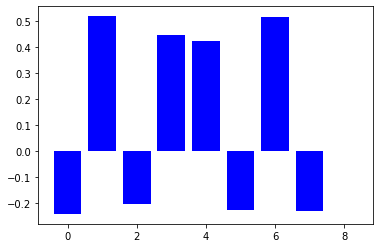

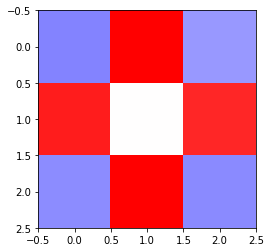

In [10]:
# Model fitting
model = LinearRegression()
model.fit(X,y)
print('R^2 score: {}'.format(model.score(X, y)))

# Finding the variance parameter
residuals = model.predict(X) - y
sigma = np.std(residuals)
print('sigma={}'.format(sigma))

# Standard visualisation of coefficients
beta = np.append(model.coef_, model.intercept_)
bar_plot(range(9), beta, color = ['blue'] * 8 + ['red'])
plt.show()

# Visualisation as a convoluton matrix
conv_mask = np.reshape(np.concatenate([model.coef_[:4],[0], model.coef_[4:]]), (3,3))
intercept = model.intercept_
plt.imshow(conv_mask, cmap='bwr')
plt.clim(-0.5, 0.5)
plt.show()

## V. Estimation of prediction quality

Let us sample locations from regular grid and replace them with predictions and visualise the outcome.

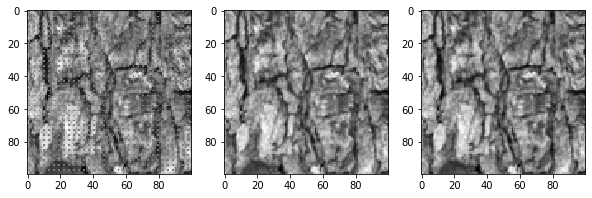

In [11]:
# Extract locations
k = 34
x = [1 + 3*i for i in range(k)] * k
y = sum([[1 + 3*i] * k for i in range(k)], [])
df2 = df = extract_texture_vectors(bw_bark, np.array(x), np.array(y), m, n , d) 

# Make prediction
X2 = df2.iloc[:, 2:].drop(columns='x05')
yp = model.predict(X2)

# Replace prediction into the image
# Linear prediction
lp_bark = bw_bark.copy()
lp_bark[df2['xm'], df2['ym']] = yp
# Mean prediction 
mp_bark = bw_bark.copy()
mp_bark[df2['xm'], df2['ym']] = np.mean(df2['x05'])

# Final visualisation
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1, 3, 1)
plt.imshow(mp_bark[:100, :100], cmap='gray')
fig.add_subplot(1, 3, 2)
plt.imshow(bw_bark[:100, :100], cmap='gray')
fig.add_subplot(1, 3, 3)
plt.imshow(lp_bark[:100, :100], cmap='gray')


## VI. Iterative image synthesis

We are going to synthesise $10\times 10$ patch by iteratively predicting values. 

* For simplicity, we keep 1 pixel frame around, since prediction of edge pixels is nontrivial.
* Our initial implementation is intensionally slow. 
* It can be made more efficient by parallelising predictions. 
* For simplicity we use the convolution mask and not the linear regeression model. 

In [12]:
from numpy.random import normal

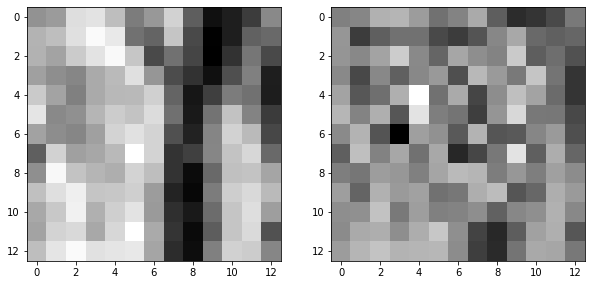

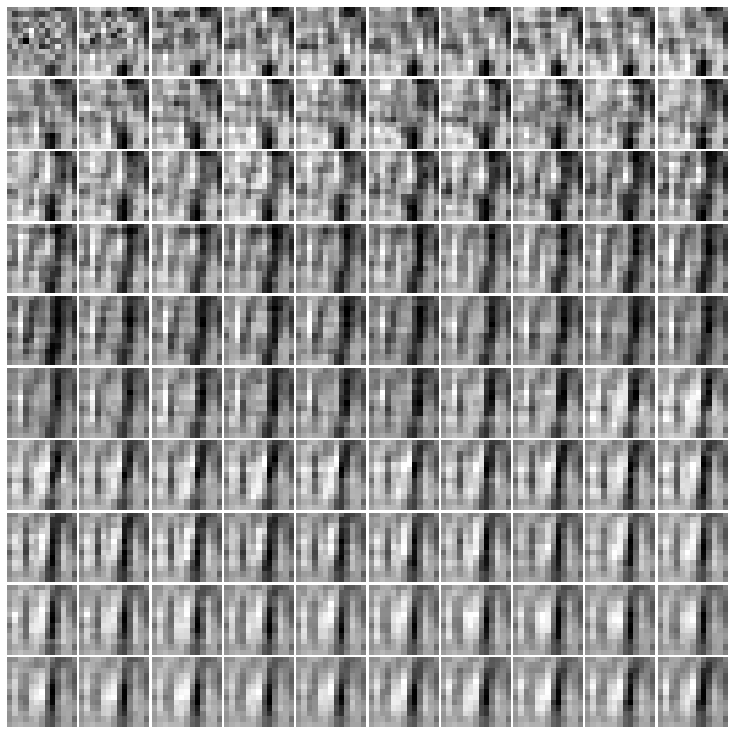

In [15]:
# Extract image and replace middle with gaussian noise
T = bw_bark[:13, :13].copy()
T[1:11,1:11] = normal(loc=np.mean(bw_bark), scale=np.std(bw_bark), size=(10,10))

fig=plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(bw_bark[:13, :13], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(T, cmap='gray')
plt.show()

k = 10
l = 10
plt.figure(figsize=(10,10))
plt.tight_layout()
gs = gridspec.GridSpec(k, l)
plt.subplot(gs[0])
plt.imshow(T, cmap='gray')
plt.axis('off')

for r in tnrange(k * l - 1):
    for x in range(10):
        for y in range(10):
            patch = T[x: x+3, y:y+3]
            yp = np.sum(patch * conv_mask) + intercept + normal(loc=0, scale=sigma)
            T[x+1, y+1] = yp
    
    plt.subplot(gs[r + 1])
    plt.imshow(T, cmap='gray')
    plt.axis('off')
    
# Covergence  
plt.subplots_adjust(wspace=0.04, hspace=0.04, left=0, right=1, bottom=0, top=1)
plt.show()    


## VII. Efficient sampling strategy

* Double-iteration over the image matrix is extremely slow.
* A single modification alters only the neighbours of its neighbours   
* Parrallel updates for $3\times 3$ patches are possible. 
* We can define 9 sub-matrices and updates each of them in parallel
* Moreover sampling parameters can be computed using linear combinations of these matrices. 
* As a result, we can use parallel operations in `numpy` and `scipy`.

# Homework

## 3.1  Predictive power of different linear models  (<font color='red'>4p</font>)  

Build linear models for different neighbourhoods:
* crosslike neighbourhood consisting of that touch the predicted pixel
* standard $3\times 3$ and $5\times 5$ neighbourhoods

Fit the model and convert the resulting coefficient vector into a convolution mask and visualise it (<font color='red'>1p</font>). 

Try also [lasso regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) to find convolutional makss with minimal number of nonzero entries. Compare different models using $R^2$ score and by visual inspection (<font color='red'>1p</font>).

Compare the prediction quality of linear methods with one non-linear method: quadratic regression with or without lasso regularisation, [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) or [two-layer neural networks](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor).
Compute $R^2$ score and do visual inspection (<font color='red'>1p</font>).


Study how universal are the resulting convolution masks. For that use models trained on one one texture to predict the values on the other texture.Compare different models using $R^2$ score and by visual inspection (<font color='red'>1p</font>).



## 3.2  Texture synthesis (<font color='red'>3p</font>)  

Choose two models with different neighbourhood shape and compare the quality of texture synthesis. For that implement more efficient sampler that updates many pixels in parralel. 
The synthesis is correct if changed pixels do not apper in the neighbourhoods of other updated pixels. All pixela must be updated once during an interation. Synthesise $100\times 100$ patch by using a correct frame from the original image. Check if different frames yield to different results (<font color='red'>1p</font>). Check if different models lead to different textures. Interpret results (<font color='red'>1p</font>). Compare how easy it is to synthesise different textures. (<font color='red'>3p</font>) 




## 3.3 Text synthesis with higher order Markov chains* (<font color='red'>3p</font>)

One of the nicest properties of the Hilbert curve is that it is self-similar. Thus, you can take a large picture and fit a large Hilbert curve on it and get a long Markov chain. Later on you can take the fitted model and fill a much smaller curve with it. Use this idea to build a texture synthesiser. Use linear models to predict the next pixel. As the data is linear, the synthesis can be done in a single pass. Compare the results with previous text synthesis methods. More details can be found in [the notebook from previous session](../03/03_markov_models_in_image_processing.ipynb). 